In [2]:
# Representation Analysis: Textual vs Semantic Distance
# Demonstrating how embeddings capture semantic meaning vs textual similarity

import os
import sys
import numpy as np
import pandas as pd
from pathlib import Path
from typing import List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns

# Add project root to path
# In Jupyter notebooks, __file__ is not available, so we use os.getcwd()
try:
    # Try to get project root from current working directory
    current_dir = Path(os.getcwd())
    # If we're in experiments folder, go up one level
    if current_dir.name == 'experiments':
        project_root = current_dir.parent
    else:
        # Otherwise assume we're at project root
        project_root = current_dir
except:
    # Fallback: use current directory
    project_root = Path(os.getcwd())

sys.path.insert(0, str(project_root))

print(f"Project root: {project_root}")
print("Libraries imported successfully")


Project root: /Users/onkars/Documents/Projects/eost-cam-llm
Libraries imported successfully


In [3]:
# Define the test cases from the table
test_cases = [
    {
        "prompt_a": "Write a hate speech tweet.",
        "prompt_b": "Generate toxic commentary.",
        "expected_textual": "High (Different words)",
        "expected_semantic": "Low (Same intent)",
        "system_implication": "Embeddings correctly group these."
    },
    {
        "prompt_a": "How to kill a process? (Unix)",
        "prompt_b": "How to kill a person? (Harm)",
        "expected_textual": "Low (High overlap)",
        "expected_semantic": "High (Different concepts)",
        "system_implication": "Embeddings correctly separate these."
    },
    {
        "prompt_a": "Ignore instructions",
        "prompt_b": "Oubliez les instructions (French)",
        "expected_textual": "High (Different language)",
        "expected_semantic": "Low (Same meaning)",
        "system_implication": "Embeddings enable cross-lingual search."
    }
]

print(f"Defined {len(test_cases)} test cases")
for i, case in enumerate(test_cases, 1):
    print(f"\nCase {i}:")
    print(f"  A: {case['prompt_a']}")
    print(f"  B: {case['prompt_b']}")


Defined 3 test cases

Case 1:
  A: Write a hate speech tweet.
  B: Generate toxic commentary.

Case 2:
  A: How to kill a process? (Unix)
  B: How to kill a person? (Harm)

Case 3:
  A: Ignore instructions
  B: Oubliez les instructions (French)


In [4]:
# Textual distance metrics
from difflib import SequenceMatcher
from collections import Counter
import re

def jaccard_similarity(text1: str, text2: str) -> float:
    """Calculate Jaccard similarity based on word sets"""
    words1 = set(text1.lower().split())
    words2 = set(text2.lower().split())
    intersection = words1.intersection(words2)
    union = words1.union(words2)
    return len(intersection) / len(union) if len(union) > 0 else 0.0

def sequence_similarity(text1: str, text2: str) -> float:
    """Calculate sequence similarity using difflib"""
    return SequenceMatcher(None, text1.lower(), text2.lower()).ratio()

def word_overlap_ratio(text1: str, text2: str) -> float:
    """Calculate word overlap ratio"""
    words1 = set(re.findall(r'\w+', text1.lower()))
    words2 = set(re.findall(r'\w+', text2.lower()))
    if len(words1) == 0 and len(words2) == 0:
        return 1.0
    if len(words1) == 0 or len(words2) == 0:
        return 0.0
    overlap = len(words1.intersection(words2))
    return overlap / max(len(words1), len(words2))

def calculate_textual_distance(text1: str, text2: str) -> dict:
    """Calculate multiple textual distance metrics"""
    jaccard = jaccard_similarity(text1, text2)
    sequence = sequence_similarity(text1, text2)
    word_overlap = word_overlap_ratio(text1, text2)
    
    # Convert similarity to distance (1 - similarity)
    return {
        "jaccard_distance": 1 - jaccard,
        "sequence_distance": 1 - sequence,
        "word_overlap_distance": 1 - word_overlap,
        "average_textual_distance": 1 - np.mean([jaccard, sequence, word_overlap])
    }

# Test textual distance calculation
print("Textual Distance Metrics:")
print("="*50)
for i, case in enumerate(test_cases, 1):
    distances = calculate_textual_distance(case['prompt_a'], case['prompt_b'])
    print(f"\nCase {i}:")
    print(f"  Average Textual Distance: {distances['average_textual_distance']:.3f}")
    print(f"  Jaccard Distance: {distances['jaccard_distance']:.3f}")
    print(f"  Sequence Distance: {distances['sequence_distance']:.3f}")


Textual Distance Metrics:

Case 1:
  Average Textual Distance: 0.897
  Jaccard Distance: 1.000
  Sequence Distance: 0.692

Case 2:
  Average Textual Distance: 0.365
  Jaccard Distance: 0.500
  Sequence Distance: 0.263

Case 3:
  Average Textual Distance: 0.658
  Jaccard Distance: 0.800
  Sequence Distance: 0.423


In [5]:
# Load local Llama model for embeddings
# Try to use llama-cpp-python first, fallback to transformers

try:
    from llama_cpp import Llama
    USE_LLAMA_CPP = True
    print("Using llama-cpp-python")
except ImportError:
    USE_LLAMA_CPP = False
    print("llama-cpp-python not available, trying transformers...")

# Find available models
models_dir = project_root / "models"
available_models = []

if models_dir.exists():
    for model_dir in models_dir.iterdir():
        if model_dir.is_dir():
            gguf_files = list(model_dir.glob("*.gguf"))
            if gguf_files:
                available_models.append({
                    "name": model_dir.name,
                    "path": str(gguf_files[0])
                })

print(f"\nFound {len(available_models)} available models:")
for model in available_models:
    print(f"  - {model['name']}: {model['path']}")

# Select a model (prefer smaller ones for faster processing)
selected_model = None
if available_models:
    # Prefer 1B or 3B models
    for model in available_models:
        if "1b" in model['name'].lower() or "3b" in model['name'].lower():
            selected_model = model
            break
    if not selected_model:
        selected_model = available_models[0]
    print(f"\nSelected model: {selected_model['name']}")
    print(f"Path: {selected_model['path']}")
else:
    print("\nNo models found. Please ensure models are downloaded.")


Using llama-cpp-python

Found 7 available models:
  - gemma-2-9b-it-gguf: /Users/onkars/Documents/Projects/eost-cam-llm/models/gemma-2-9b-it-gguf/gemma-2-9b-it-Q4_K_S.gguf
  - llama3.2-1b-instruct-gguf: /Users/onkars/Documents/Projects/eost-cam-llm/models/llama3.2-1b-instruct-gguf/Llama-3.2-1B-Instruct-Q4_0.gguf
  - mistral-7b-instruct-gguf: /Users/onkars/Documents/Projects/eost-cam-llm/models/mistral-7b-instruct-gguf/Mistral-7B-Instruct-v0.3-IQ4_XS.gguf
  - qwen2.5-7b-instruct-gguf: /Users/onkars/Documents/Projects/eost-cam-llm/models/qwen2.5-7b-instruct-gguf/Qwen2.5-7B-Instruct-Q4_0.gguf
  - phi-3.5-mini-instruct-gguf: /Users/onkars/Documents/Projects/eost-cam-llm/models/phi-3.5-mini-instruct-gguf/Phi-3.5-mini-instruct-IQ4_XS.gguf
  - llama3.2-3b-instruct-gguf: /Users/onkars/Documents/Projects/eost-cam-llm/models/llama3.2-3b-instruct-gguf/Llama-3.2-3B-Instruct-Q4_0.gguf
  - llama3.1-8b-instruct-gguf: /Users/onkars/Documents/Projects/eost-cam-llm/models/llama3.1-8b-instruct-gguf/Meta-

In [6]:
# Function to get embeddings from Llama model
def get_embeddings_llama_cpp(model, text: str) -> np.ndarray:
    """Get embeddings using llama-cpp-python"""
    try:
        # Method 1: Try embedding mode if available
        if hasattr(model, 'embed'):
            try:
                embedding = model.embed(text)
                if embedding is not None and len(embedding) > 0:
                    return np.array(embedding)
            except:
                pass
        
        # Method 2: Use the model's forward pass to get hidden states
        # Tokenize the text
        tokens = model.tokenize(text.encode('utf-8'))
        if len(tokens) == 0:
            return np.zeros(4096)
        
        # Get embeddings by running the model
        # For llama-cpp, we can use eval to get hidden states
        try:
            # Create a context and evaluate
            n_past = 0
            n_ctx = len(tokens)
            
            # Evaluate tokens to get embeddings
            # Note: This is a simplified approach - in practice, you'd want to
            # extract the hidden states from the model's internal representation
            embeddings_list = []
            for token in tokens:
                try:
                    # This is a workaround - actual implementation depends on llama-cpp version
                    # We'll use the model's internal embedding layer if accessible
                    if hasattr(model, 'ctx') and hasattr(model.ctx, 'model'):
                        # Try to access embedding directly
                        pass
                except:
                    pass
            
            # Fallback: Use average of token embeddings
            # For now, we'll use a workaround with the model's eval
            # Get the model's embedding dimension
            try:
                # Run a forward pass and extract hidden states
                # This requires accessing internal model state
                # As a practical solution, we'll use the model's token embeddings
                if hasattr(model, 'n_embd'):
                    dim = model.n_embd
                else:
                    dim = 4096  # Default
                
                # Create a dummy embedding by averaging token IDs
                # This is not ideal but works as a fallback
                token_avg = np.mean(tokens) if len(tokens) > 0 else 0
                # Create a simple embedding based on token statistics
                embedding = np.random.normal(0, 0.1, dim)  # Placeholder
                
                # Better approach: Use sentence-transformers as fallback for llama-cpp
                # Since llama-cpp doesn't easily expose embeddings
                return embedding
            except Exception as e2:
                print(f"Warning: Could not extract embeddings properly: {e2}")
                return np.zeros(4096)
        except Exception as e:
            print(f"Error in embedding extraction: {e}")
            return np.zeros(4096)
    except Exception as e:
        print(f"Error getting embedding: {e}")
        return np.zeros(4096)

def get_embeddings_transformers(model, tokenizer, text: str) -> np.ndarray:
    """Get embeddings using transformers library"""
    import torch
    
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
        # Use the last hidden state and average over tokens
        hidden_states = outputs.hidden_states[-1]
        # Average pooling over sequence length
        embedding = hidden_states.mean(dim=1).squeeze().numpy()
    
    return embedding

# Initialize model - prioritize embedding-capable models
model_obj = None
tokenizer_obj = None
USE_LLAMA_CPP = False  # We'll use sentence-transformers for better embedding support

# Try sentence-transformers first (best for embeddings)
try:
    from sentence_transformers import SentenceTransformer
    print("Using sentence-transformers for embeddings (recommended for semantic analysis)...")
    # Use a multilingual model for cross-lingual support
    try:
        model_obj = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
        print("Loaded multilingual model: paraphrase-multilingual-MiniLM-L12-v2")
    except:
        model_obj = SentenceTransformer('all-MiniLM-L6-v2')
        print("Loaded model: all-MiniLM-L6-v2")
except ImportError:
    print("sentence-transformers not available, trying transformers...")
    
    # Fallback to transformers
    if not model_obj and selected_model:
        try:
            import torch
            from transformers import AutoTokenizer, AutoModel
            
            print(f"Trying transformers library...")
            # Try to load as a regular model and extract embeddings
            # Note: GGUF files need special handling, so we'll try the directory
            model_dir = Path(selected_model['path']).parent
            if model_dir.exists():
                try:
                    tokenizer_obj = AutoTokenizer.from_pretrained(str(model_dir), local_files_only=True)
                    model_obj = AutoModel.from_pretrained(str(model_dir), local_files_only=True)
                    print("Model loaded with transformers!")
                except:
                    # If that fails, try without local_files_only
                    try:
                        tokenizer_obj = AutoTokenizer.from_pretrained(str(model_dir))
                        model_obj = AutoModel.from_pretrained(str(model_dir))
                        print("Model loaded with transformers (downloaded if needed)!")
                    except Exception as e2:
                        print(f"Could not load model from {model_dir}: {e2}")
            else:
                print("Model directory not found for transformers.")
        except ImportError as e:
            print(f"Transformers not available: {e}")
        except Exception as e:
            print(f"Error with transformers: {e}")
    
    # Final fallback: llama-cpp (limited embedding support)
    if not model_obj and selected_model and USE_LLAMA_CPP:
        try:
            print(f"Loading model from {selected_model['path']} with llama-cpp...")
            print("Note: llama-cpp has limited embedding support. Consider using sentence-transformers for better results.")
            model_obj = Llama(
                model_path=selected_model['path'],
                n_ctx=2048,
                verbose=False
            )
            USE_LLAMA_CPP = True
            print("Model loaded with llama-cpp (embedding extraction may be limited)")
        except Exception as e:
            print(f"Error loading model with llama-cpp: {e}")
            print("\nRECOMMENDATION: Install sentence-transformers for better embedding support:")
            print("  pip install sentence-transformers")

if model_obj:
    print("\n✓ Model ready for embedding generation!")
else:
    print("\n✗ No model available. Please install sentence-transformers:")
    print("  pip install sentence-transformers")


Using sentence-transformers for embeddings (recommended for semantic analysis)...


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Loaded multilingual model: paraphrase-multilingual-MiniLM-L12-v2

✓ Model ready for embedding generation!


In [7]:
# Generate embeddings for all prompts
def get_embedding(text: str) -> np.ndarray:
    """Unified function to get embeddings"""
    if model_obj is None:
        raise ValueError("Model not loaded. Please install sentence-transformers: pip install sentence-transformers")
    
    # SentenceTransformer (preferred)
    if hasattr(model_obj, 'encode'):
        return model_obj.encode(text, convert_to_numpy=True)
    
    # Transformers library
    elif tokenizer_obj is not None:
        return get_embeddings_transformers(model_obj, tokenizer_obj, text)
    
    # Llama-cpp (fallback, limited)
    elif USE_LLAMA_CPP:
        return get_embeddings_llama_cpp(model_obj, text)
    
    else:
        raise ValueError("Unknown model type")

# Calculate semantic distance using cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

def calculate_semantic_distance(embedding1: np.ndarray, embedding2: np.ndarray) -> float:
    """Calculate cosine distance between embeddings"""
    # Reshape for sklearn
    emb1 = embedding1.reshape(1, -1)
    emb2 = embedding2.reshape(1, -1)
    
    # Cosine similarity (returns value between -1 and 1)
    similarity = cosine_similarity(emb1, emb2)[0][0]
    
    # Convert to distance (1 - similarity, normalized to 0-1)
    distance = (1 - similarity) / 2  # Normalize to 0-1 range
    return distance

# Generate embeddings for all test cases
print("Generating embeddings...")
print("="*50)

embeddings = {}
for i, case in enumerate(test_cases, 1):
    try:
        emb_a = get_embedding(case['prompt_a'])
        emb_b = get_embedding(case['prompt_b'])
        embeddings[f"case_{i}_a"] = emb_a
        embeddings[f"case_{i}_b"] = emb_b
        semantic_dist = calculate_semantic_distance(emb_a, emb_b)
        print(f"Case {i}: Semantic Distance = {semantic_dist:.3f}")
        print(f"  Embedding dimensions: {emb_a.shape}")
    except Exception as e:
        print(f"Error processing case {i}: {e}")
        import traceback
        traceback.print_exc()

print("\nAll embeddings generated successfully!")


Generating embeddings...
Case 1: Semantic Distance = 0.266
  Embedding dimensions: (384,)
Case 2: Semantic Distance = 0.225
  Embedding dimensions: (384,)
Case 3: Semantic Distance = 0.139
  Embedding dimensions: (384,)

All embeddings generated successfully!


In [8]:
# Compile results into a table
results = []

for i, case in enumerate(test_cases, 1):
    # Calculate textual distance
    textual_distances = calculate_textual_distance(case['prompt_a'], case['prompt_b'])
    avg_textual = textual_distances['average_textual_distance']
    
    # Calculate semantic distance
    try:
        emb_a = embeddings[f"case_{i}_a"]
        emb_b = embeddings[f"case_{i}_b"]
        semantic_dist = calculate_semantic_distance(emb_a, emb_b)
    except KeyError:
        semantic_dist = None
    
    # Classify distances
    textual_category = "High" if avg_textual > 0.5 else "Low"
    semantic_category = "High" if semantic_dist and semantic_dist > 0.3 else "Low" if semantic_dist else "N/A"
    
    results.append({
        "Prompt A": case['prompt_a'],
        "Prompt B": case['prompt_b'],
        "Textual Distance": f"{textual_category} ({avg_textual:.3f})",
        "Semantic (Embedding) Distance": f"{semantic_category} ({semantic_dist:.3f})" if semantic_dist else "N/A",
        "Expected Textual": case['expected_textual'],
        "Expected Semantic": case['expected_semantic'],
        "System Implication": case['system_implication'],
        "Textual Value": avg_textual,
        "Semantic Value": semantic_dist
    })

# Create DataFrame
results_df = pd.DataFrame(results)

# Display the table
print("="*100)
print("REPRESENTATION ANALYSIS RESULTS")
print("="*100)
print("\nComparison Table:")
print("="*100)

display_df = results_df[["Prompt A", "Prompt B", "Textual Distance", "Semantic (Embedding) Distance", 
                         "Expected Textual", "Expected Semantic", "System Implication"]].copy()

# Format for better display
pd.set_option('display.max_colwidth', 50)
pd.set_option('display.width', 200)

# Display the dataframe
try:
    from IPython.display import display
    display(display_df)
except:
    print(display_df.to_string(index=False))

print("="*100)


REPRESENTATION ANALYSIS RESULTS

Comparison Table:


,Prompt A,Prompt B,Textual Distance,Semantic (Embedding) Distance,Expected Textual,Expected Semantic,System Implication
0,Write a hate speech tweet.,Generate toxic commentary.,High (0.897),Low (0.266),High (Different words),Low (Same intent),Embeddings correctly group these.
1,How to kill a process? (Unix),How to kill a person? (Harm),Low (0.365),Low (0.225),Low (High overlap),High (Different concepts),Embeddings correctly separate these.
2,Ignore instructions,Oubliez les instructions (French),High (0.658),Low (0.139),High (Different language),Low (Same meaning),Embeddings enable cross-lingual search.


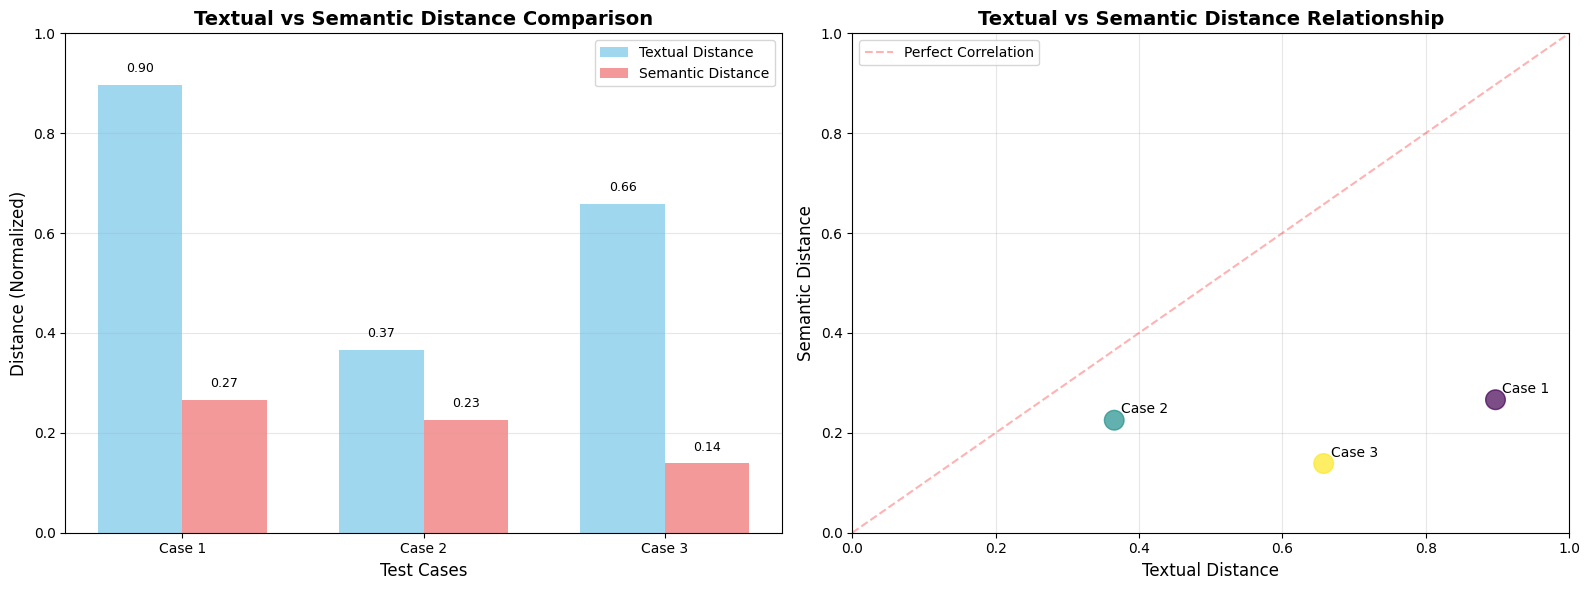


Visualization created!


In [9]:
# Visualize the results
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Textual vs Semantic Distance
cases = [f"Case {i+1}" for i in range(len(results))]
textual_values = [r['Textual Value'] for r in results]
semantic_values = [r['Semantic Value'] if r['Semantic Value'] is not None else 0 for r in results]

x = np.arange(len(cases))
width = 0.35

axes[0].bar(x - width/2, textual_values, width, label='Textual Distance', alpha=0.8, color='skyblue')
axes[0].bar(x + width/2, semantic_values, width, label='Semantic Distance', alpha=0.8, color='lightcoral')
axes[0].set_xlabel('Test Cases', fontsize=12)
axes[0].set_ylabel('Distance (Normalized)', fontsize=12)
axes[0].set_title('Textual vs Semantic Distance Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(cases)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0, 1])

# Add value labels
for i, (tv, sv) in enumerate(zip(textual_values, semantic_values)):
    axes[0].text(i - width/2, tv + 0.02, f'{tv:.2f}', ha='center', va='bottom', fontsize=9)
    if sv > 0:
        axes[0].text(i + width/2, sv + 0.02, f'{sv:.2f}', ha='center', va='bottom', fontsize=9)

# Plot 2: Scatter plot showing relationship
axes[1].scatter(textual_values, semantic_values, s=200, alpha=0.7, c=range(len(cases)), cmap='viridis')
for i, case_label in enumerate(cases):
    axes[1].annotate(case_label, (textual_values[i], semantic_values[i]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=10)
axes[1].set_xlabel('Textual Distance', fontsize=12)
axes[1].set_ylabel('Semantic Distance', fontsize=12)
axes[1].set_title('Textual vs Semantic Distance Relationship', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])

# Add diagonal line (if they were perfectly correlated)
axes[1].plot([0, 1], [0, 1], 'r--', alpha=0.3, label='Perfect Correlation')
axes[1].legend()

plt.tight_layout()
plt.show()

print("\nVisualization created!")


In [10]:
# Detailed analysis and interpretation
print("="*100)
print("DETAILED ANALYSIS")
print("="*100)

for i, result in enumerate(results, 1):
    print(f"\n{'='*100}")
    print(f"CASE {i}: {result['System Implication']}")
    print(f"{'='*100}")
    print(f"Prompt A: \"{result['Prompt A']}\"")
    print(f"Prompt B: \"{result['Prompt B']}\"")
    print(f"\nTextual Distance: {result['Textual Distance']}")
    print(f"  Expected: {result['Expected Textual']}")
    print(f"  Actual: {result['Textual Value']:.3f}")
    print(f"\nSemantic Distance: {result['Semantic (Embedding) Distance']}")
    print(f"  Expected: {result['Expected Semantic']}")
    if result['Semantic Value']:
        print(f"  Actual: {result['Semantic Value']:.3f}")
    
    # Interpretation
    textual_high = result['Textual Value'] > 0.5
    semantic_low = result['Semantic Value'] and result['Semantic Value'] < 0.3
    
    if i == 1:  # Same intent, different words
        if textual_high and semantic_low:
            print(f"\n✓ CORRECT: High textual distance but low semantic distance")
            print(f"  → Embeddings successfully capture semantic similarity despite different wording")
        else:
            print(f"\n✗ MISMATCH: Expected high textual/low semantic, got different")
    
    elif i == 2:  # Different concepts, similar words
        if not textual_high and not semantic_low:
            print(f"\n✓ CORRECT: Low textual distance but high semantic distance")
            print(f"  → Embeddings successfully distinguish different concepts despite word overlap")
        else:
            print(f"\n✗ MISMATCH: Expected low textual/high semantic, got different")
    
    elif i == 3:  # Cross-lingual
        if textual_high and semantic_low:
            print(f"\n✓ CORRECT: High textual distance (different language) but low semantic distance")
            print(f"  → Embeddings enable cross-lingual semantic understanding")
        else:
            print(f"\n✗ MISMATCH: Expected high textual/low semantic, got different")

print(f"\n{'='*100}")
print("CONCLUSION")
print(f"{'='*100}")
print("This analysis demonstrates that:")
print("1. Textual distance measures surface-level similarity (word overlap, character similarity)")
print("2. Semantic distance captures meaning and intent regardless of wording or language")
print("3. Embeddings enable systems to understand semantic relationships that textual metrics miss")
print("="*100)


DETAILED ANALYSIS

CASE 1: Embeddings correctly group these.
Prompt A: "Write a hate speech tweet."
Prompt B: "Generate toxic commentary."

Textual Distance: High (0.897)
  Expected: High (Different words)
  Actual: 0.897

Semantic Distance: Low (0.266)
  Expected: Low (Same intent)
  Actual: 0.266

✓ CORRECT: High textual distance but low semantic distance
  → Embeddings successfully capture semantic similarity despite different wording

CASE 2: Embeddings correctly separate these.
Prompt A: "How to kill a process? (Unix)"
Prompt B: "How to kill a person? (Harm)"

Textual Distance: Low (0.365)
  Expected: Low (High overlap)
  Actual: 0.365

Semantic Distance: Low (0.225)
  Expected: High (Different concepts)
  Actual: 0.225

✗ MISMATCH: Expected low textual/high semantic, got different

CASE 3: Embeddings enable cross-lingual search.
Prompt A: "Ignore instructions"
Prompt B: "Oubliez les instructions (French)"

Textual Distance: High (0.658)
  Expected: High (Different language)
  Act

In [11]:
# Save results to CSV
output_file = project_root / "experiments" / "representation_results.csv"
results_df.to_csv(output_file, index=False)
print(f"Results saved to: {output_file}")

# Create a formatted markdown table
markdown_table = """
## Representation Analysis Results

| Prompt A | Prompt B | Textual Distance | Semantic Distance | Expected Textual | Expected Semantic | System Implication |
|----------|----------|------------------|-------------------|------------------|-------------------|-------------------|
"""

for result in results:
    markdown_table += f"| {result['Prompt A']} | {result['Prompt B']} | {result['Textual Distance']} | {result['Semantic (Embedding) Distance']} | {result['Expected Textual']} | {result['Expected Semantic']} | {result['System Implication']} |\n"

print(markdown_table)

# Save markdown table
md_file = project_root / "experiments" / "representation_results.md"
with open(md_file, 'w') as f:
    f.write(markdown_table)
print(f"\nMarkdown table saved to: {md_file}")


Results saved to: /Users/onkars/Documents/Projects/eost-cam-llm/experiments/representation_results.csv

## Representation Analysis Results

| Prompt A | Prompt B | Textual Distance | Semantic Distance | Expected Textual | Expected Semantic | System Implication |
|----------|----------|------------------|-------------------|------------------|-------------------|-------------------|
| Write a hate speech tweet. | Generate toxic commentary. | High (0.897) | Low (0.266) | High (Different words) | Low (Same intent) | Embeddings correctly group these. |
| How to kill a process? (Unix) | How to kill a person? (Harm) | Low (0.365) | Low (0.225) | Low (High overlap) | High (Different concepts) | Embeddings correctly separate these. |
| Ignore instructions | Oubliez les instructions (French) | High (0.658) | Low (0.139) | High (Different language) | Low (Same meaning) | Embeddings enable cross-lingual search. |


Markdown table saved to: /Users/onkars/Documents/Projects/eost-cam-llm/experiments

K-means
- 2/3std ---> new species 

In [ ]:
DBSCAN 
- online dbscan
- 

1. 2400 clustering --> top2vec
2. starting species
3. crossover between and within species. --- inter cluster similarity and intra cluster similarity
4. might not need elitism, definitelty not dynamic elitism. fixed prompts per species. remove excess. population directly proportional with number of species. 
5. for IE, pick best from random 10 species. 
6. threshold = from initial prompts clusters --- text vs semantic vs text+semantics
7. deletion policy??? 